In [17]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2 as pg
import os
import random
import time
import numpy as np

# Query Data 

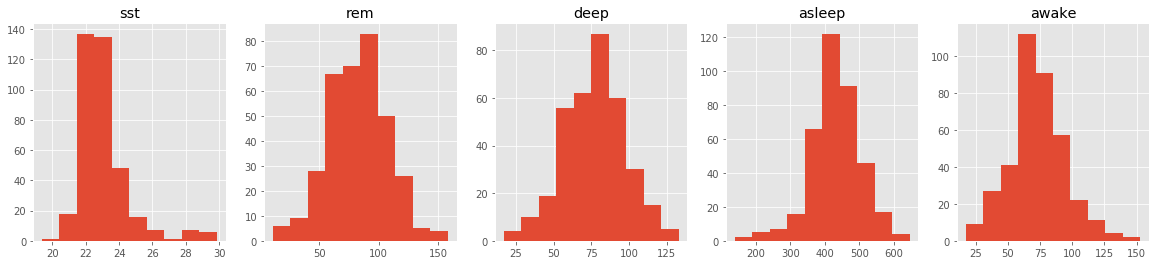

In [72]:
conn = pg.connect(
    host=os.getenv('WMSDB_HOST'),
    database=os.getenv('WMSDB_DB'),
    user=os.getenv('WMSDB_USER'),
    password=os.getenv('WMSDB_PWD')
)
cur = conn.cursor()
cur.execute(f'''
    SELECT
        date,
        CASE WHEN start::TIME BETWEEN TIME '00:00:00' AND TIME '12:00:00' 
            THEN (extract(epoch from start::TIME) + 86400) /3600
            ELSE extract(epoch from start::TIME) /3600
            END sst,
        rem,
        deep,
        asleep,
        awake
    FROM sleep
    WHERE ismain = true
    AND sj_id = 32;
''')
records = cur.fetchall()
conn.close()
df = pd.DataFrame(records, columns=[f[0] for f in cur.description])
fig, axs = plt.subplots(1,5, figsize=(20,4))
for i, c in enumerate(['sst', 'rem', 'deep', 'asleep', 'awake']):
    axs[i].hist(df.loc[df[c].notna(), c])
    axs[i].set_title(c)

# Bootstrap?

obs_mean: 23.047562056737583, obs_std: 1.4917955426882128, obs_size: 376
sampling_mean: 1.4757490691365265, sampling_std: 0.19896674934634112


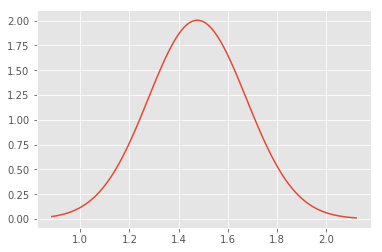

In [136]:
sst = df['sst'].copy()
print(f'obs_mean: {np.mean(sst)}, obs_std: {np.std(sst)}, obs_size: {sst.shape[0]}')
bootstrap_size = 1000
sample_size = 100 # how to determine the proper sample size to ensure the normality of the sampling distribution?

sample_stds = []
for _ in range(bootstrap_size):
    sample = []
    for _ in range(sample_size):
        sample.append(sst[random.randrange(sst.shape[0])])
    sample_stds.append(np.std(sample))

print(f'sampling_mean: {np.mean(sample_stds)}, sampling_std: {np.std(sample_stds)}')
sample_dist = ss.norm(np.mean(sample_stds), np.std(sample_stds))
pdf_xs = np.linspace(min(sample_stds), max(sample_stds), 100)
pdf_ys = [sample_dist.pdf(x) for x in pdf_xs]
# plt.hist(sample_stds)
plt.plot(pdf_xs, pdf_ys)


In [134]:
def trunc_outliers(X):
    X = X[X.notna()]
    o_cnt = float('inf')
    while o_cnt:
        lq = np.percentile(X, 25)
        uq = np.percentile(X, 75)
        rg = (uq - lq) * 1.5
        lo = lq - rg
        uo = uq + rg
        o_cnt = X[(X < lo) | (X >= uo)].shape[0]
        X = X[(X >= lo) & (X < uo)].copy()
    return X    

347

# Estimate Population Distribution 

mean: 23.05, std: 1.49, skew: 2.05, kurt: 5.77
lower outlier bound: 20.23, upper outlier bound: 25.44
number of outliers: 25
mean: 22.75, std: 0.88, skew: 0.36, kurt: 0.12
lower outlier bound: 20.38, upper outlier bound: 25.09
number of outliers: 4
mean: 22.73, std: 0.84, skew: 0.22, kurt: -0.12
lower outlier bound: 20.41, upper outlier bound: 25.03
number of outliers: 0
0.030563441176767524


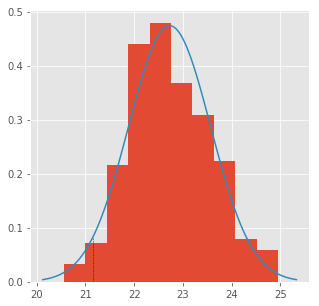

In [118]:
def trunc_outliers(X):
    lq = np.percentile(X[X.notna()], 25)
    uq = np.percentile(X[X.notna()], 75)
    rg = (uq-lq) * 1.5
    lo = lq - rg
    uo = uq + rg
    t = X[(X < uo) & (X >= lo)].sort_values().copy()
    o = X[(X >= uo) | (X < lo)].sort_values().copy()
    m, std, s, k = np.mean(X), np.std(X), ss.skew(X), ss.kurtosis(X)
    print(f'''mean: {round(m, 2)}, std: {round(std, 2)}, skew: {round(s,  2)}, kurt: {round(k,2)}''')
    print(f'lower outlier bound: {round(lo, 2)}, upper outlier bound: {round(uo, 2)}')
    print(f'number of outliers: {o.shape[0]}')
    return t, o

def plot_pop_hist(ax, X):
    ax.hist(X, density=True)
    
def plot_pop_norm(ax, dist):
    mi = dist.ppf(0.001)
    ma = dist.ppf(0.999)
    pdf_xs = np.linspace(mi, ma, 100)
    pdf_ys = [dist.pdf(x) for x in pdf_xs]
    ax.plot(pdf_xs, pdf_ys)
    
def plot_rand_value(ax, dist):
    ax.vlines(x, 0, dist.pdf(x), linewidth=0.5, colors='blue', linestyles='dashed')


t = df['sst'].copy()
o = df['sst'].copy()
while len(o):
    t, o = trunc_outliers(t)


X = t
n = len(X)
m = np.mean(X)
s = np.std(X, ddof=1)
dist = ss.norm(m, s)
x = dist.rvs(1)[0]
p = dist.cdf(x) if x < m else 1 - dist.cdf(x)

fig, ax = plt.subplots(1,1, figsize=(5,5))
plot_pop_hist(ax, X)
plot_pop_norm(ax, dist)
plot_rand_value(ax, dist)
print(p)

# Estimate Sampling Distribution 

year: 2020, week: 14 (from 2020-03-30 to 2020-04-05)
stat: sample mean, m: 22.73, se: 0.32, x: 22:28:21, p-value: 0.2129
stat: sample std, m: 0.84, se: 0.32, x: 1.02, p-value: 0.2833


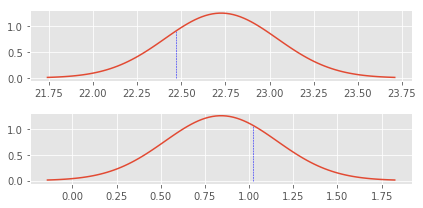

In [99]:
# outliers should only be truncated for estimating the population.
# outliers should not get truncated for samples being tested against the population.

def get_mean(srs):
    return np.nan if srs.isna().any() else srs.mean()

def get_std(srs):
    return np.nan if srs.isna().any() else srs.std()

def get_full_weeks():
    df['yr'] = df['date'].apply(lambda x: x.isocalendar()[0])
    df['wk'] = df['date'].apply(lambda x: x.isocalendar()[1])
    df_gp = df.groupby(['yr', 'wk'], as_index=False)
    df_agg = df_gp.agg({
        'date' : ['count', 'min', 'max'], 
        'sst' : [get_std, get_mean], 
        'rem' : get_mean, 
        'deep' : get_mean, 
        'asleep' : get_mean,
        'awake' : get_mean
    })
    df_agg.columns = ['yr', 'wk', 'cnt', 'ws', 'we', 'ssst', 'msst', 'mrem', 'mdeep', 'masleep', 'mawake']
    fw = df_agg[df_agg['cnt'] == 7]
    return fw

def plot_sampling_dist(ax, dist):
    mi = dist.ppf(0.001)
    ma = dist.ppf(0.999)
    pdf_xs = np.linspace(mi, ma, 100)
    pdf_ys = [dist.pdf(x) for x in pdf_xs]
    ax.plot(pdf_xs, pdf_ys)

def plot_most_recent(ax, dist, x):
    ax.vlines(x, 0, dist.pdf(x), linewidth=0.5, colors='blue', linestyles='dashed')


m_std = np.std(X, ddof=1)
s_std = np.std(X, ddof=1)

se = s/np.sqrt(7)
dist = ss.norm(m, se)
fws = get_full_weeks()
x = fws.loc[fws.shape[0],'msst']
p = dist.cdf(x) if x < m else 1 - dist.cdf(x)

se_std = s_std / np.sqrt(7)
dist_std = ss.norm(m_std, se_std)
x_std = fws.loc[fws.shape[0],'ssst']
p_std = dist_std.cdf(x_std) if x_std < m_std else 1 - dist_std.cdf(x_std) 

fig, axs = plt.subplots(2,1, figsize=(6,3))
plot_sampling_dist(axs[0], dist)
plot_most_recent(axs[0], dist, x)
plot_sampling_dist(axs[1], dist_std)
plot_most_recent(axs[1], dist_std, x_std)
fig.tight_layout()

yr = rfw['date'].min().isocalendar()[0]
wk = rfw['date'].min().isocalendar()[1]
ws = rfw['date'].min()
we = rfw['date'].max()
x = time.strftime('%H:%M:%S', time.gmtime(x*3600))
print(f"year: {yr}, week: {wk} (from {ws} to {we})")
print(f"stat: sample mean, m: {round(m,2)}, se: {round(se,2)}, x: {x}, p-value: {p:.4}")
print(f"stat: sample std, m: {round(m_std,2)}, se: {round(se_std,2)}, x: {round(x_std,2)}, p-value: {round(p_std,4)}")

